In [1]:
from time import time
from tqdm import tqdm
from pathlib import Path

import pandas as pd
import numpy as np
np.random.seed(42)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression,  f_classif

from sklearn.linear_model import LinearRegression, Ridge,  Lasso, SGDRegressor, ElasticNet, Lars, OrthogonalMatchingPursuit,\
                                 BayesianRidge, ARDRegression, HuberRegressor, RANSACRegressor, PassiveAggressiveRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

*virtual environment recommended for [PyCaret](https://pycaret.gitbook.io/docs/), as older versions of pandas and numpy are required.*

[API reference](https://pycaret.readthedocs.io/en/latest/index.html)

In [71]:
import pycaret
pycaret.__version__

'3.1.0'

### Contents
 - **[Rubric Requirements](#Rubric-Requirements)**
   - [Data Load. Train, test split](#Split)
     - Setting consistent random seeds used in place of persisting split and scaled data. 
   - [Dummy Features](#Dummy-Features)
     - I am only using numerical features for this project. Dummy features used for description only.
   - [Data Scaling](#Data-Scaling)
     - Demonstration purposes. Model performance tested with scaled and unscaled features.
 - **[Preliminary Studies - Regression for `home_margin`](#Preliminary-Studies)**
   - Note that model selection is carried out in parallel with the following studies. Only better performing models will be progressed to the next notebooks.
   - [Feature Selection](#Feature-Selection) `sklearn`
     - *will not consider ensemble models*
   - [Data Normalization](#Normalization) `PyCaret`
     - test effects of normalization on performance for models
       - use all data for ensemble models
       - select 8 features for linear models and kNN
   - *Model Selection, Hyperparameter Tuning* - **[tuning notebook](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/18.3_Modeling_selection.ipynb)**
   - *Outlier removal and further hyperparameter tuning studied after model selection.* - **[modeling notebook](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/18.3_Modeling_final.ipynb)**

### Rubric Requirements
 - separate into training and validation sets
   - training set will be used for model cross-validation and tuning
 - create dummy features for description: game_type
 - scale data

In [2]:
data = pd.read_parquet(Path('data/game_stats.parquet'))
data.shape

(1521, 20)

##### Split

In [3]:
X = data.iloc[:,6:-2]
y1 = data['home_margin'] # target for regression
y2 = data['home_win'] # target for classification


# Initial Split, this test set will be hold out for scoring
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2)
y2_train = y2[y1_train.index]
y2_test = y2[y1_test.index]
features = X_train.columns
print(X_train.shape)
print(X_test.shape)

(1216, 12)
(305, 12)


In [6]:
X.columns

Index(['home_completions', 'away_completions', 'home_throws', 'away_throws',
       'home_blocks', 'away_blocks', 'home_turnovers', 'away_turnovers',
       'home_completion_rate', 'away_completion_rate', 'comp_rate_diff',
       'block_turnover_diff'],
      dtype='object')

##### Dummy Features
 - `game_type`, based on `week` column, only used for description
 - categorical features, such as `team` could be interesting to assess in subsequent studies
   - how important is team identity as a feature in predicting win probability?

In [73]:
d = pd.read_parquet(Path('data/clean_1/game_stats_2023-09-19.parquet'))
d = d.loc[data.index,'week']
d = d.astype(str)
d.unique()

array(['1', '2', '3', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', 'championship', '4', 'playoffs', '16', '17',
       'allstars', 'divisional-champ', 'semi-finals'], dtype=object)

In [76]:
# all-stars games
data.loc[d[d=='allstars'].index,'game_type'] = 'demo'

# regular games
reg_weeks = [str(i+1) for i in range(17)]
data.loc[d[d.isin(reg_weeks)].index,'game_type'] = 'regular'

# playoff games, post-season
data.loc[data[data.game_type.isna()].index, 'game_type'] = 'playoffs'

data.game_type.value_counts()

regular     1435
playoffs      85
demo           1
Name: game_type, dtype: int64

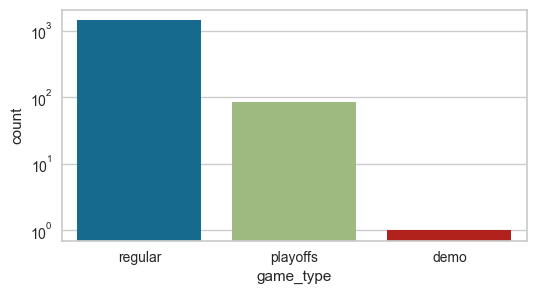

In [86]:
plt.figure(figsize=(6,3))
sns.countplot(x=data.game_type)
plt.yscale('log')
plt.show()

In [75]:
game_type = data.game_type
data.drop(columns='game_type', inplace=True)

##### Data Scaling

In [63]:
# Scale data, fit scaler to training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Preliminary Studies
 - [Feature Selection](#Feature-Selection) | [Normalization](#Normalization)
 - **evaluation notes**
   - scoring metrics: `R2, MAE, MSE and RMSE, MAPE, RMSLE`
     - background gradients used to facilitate evaluation
       - background gradients and scroll bars won't appear on repository, open notebook in **Jupyter** for better viewing.
     - metrics tend to correlate, allowing performance of models to be directly compared
       - kNN and outlier-robust models tend to have lower MAE,MAPE than other metrics would suggest
       - RMSE tends to correlate more with R2 than MAE, choices will be made in final model selection
 - **conclusions**
   - previously determined good cross-validation parameters for dataset size: **75/25 split, 10 fold**
   - select 7 or 8 features to improve performance of certain **linear models** and **k-nearest-neighbors**
   - utilize all features, with scaling for **ensemble models**. normalization helps/doesn't hurt performance of most models. 
       - extra trees diminishes slightly, but not enough to treat separately
       - adaboost hurts performance, but will not progress
 - ---
 - **progress for tuning. compare directly against each other | [notebook link](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/18.3_Modeling_selection.ipynb)**
   - **<font color="darkgreen">all data, normalized (scaled)</font>**
     - `catboost, extra trees, lightGBM, GBR, XGB`
       - XGB over RandomForest due to prior tuning results
   - **<font color="darkgreen">select 7,8 features. test with scaled and unscaled.</font>**
     - `knn, lr, ridge, sgd, lar, br, kr, ard, llar`
       - never scale: kNN, kr, llar
       - only scale: SGD, br

#### Feature Selection

**Worthwhile for some linear models. This study also serves as a baseline comparision for some models.**

 - some linear models show better performance when eliminating features (from 12 total)
   - *those that do not*: ElasticNet, PassiveAgressiveRegressor 
 - peak performance is at 5-8 features, selected using univariate SelectKBest `f_regression`
   - particularly for: `LinReg, Ridge, SGD, LAR, BayesianRidge, ARDRegressor, KernelRidge`
   - 8 features encompasses the engineered features + blocks and turnovers. 
     - removes throws and completions (captured + normalized in completion_rate)
 - outlier-robust regressors ideal feature selection depends on metric to optimize
 - OMP and Lasso performance did not vary with feature selection, skipping to speed up run time
 
 

**Feature Importance for `home_margin`, `home_win`**
 - **<font color="purple">Strong</font> | <font color="aquamarine">Fair</font> | <font color="yellow">Weak</font>** 

In [5]:
kbest_margin = SelectKBest(score_func=f_regression, k='all')
kbest_margin.fit(X_train,y1_train)
pd.DataFrame(kbest_margin.scores_,index=features).sort_values(0,ascending=False).style\
        .background_gradient(subset=[0], cmap='viridis', gmap=np.log(kbest_margin.scores_))

,0
block_turnover_diff,6565.951175
comp_rate_diff,605.031463
home_blocks,508.052295
away_turnovers,469.406579
away_blocks,288.691841
away_completion_rate,172.573514
home_turnovers,172.203353
home_completion_rate,103.210744
away_throws,5.716364
home_throws,2.929064


In [6]:
kbest_margin = SelectKBest(score_func=f_classif, k='all')
kbest_margin.fit(X_train,y1_train)
pd.DataFrame(kbest_margin.scores_,index=features).sort_values(0,ascending=False).style\
        .background_gradient(subset=[0], cmap='viridis', gmap=np.log(kbest_margin.scores_))

,0
block_turnover_diff,136.769056
comp_rate_diff,13.851583
home_blocks,12.947181
away_turnovers,12.185358
away_blocks,7.740306
home_turnovers,6.367641
away_completion_rate,5.866289
home_completion_rate,3.911307
away_throws,1.991118
away_completions,1.971998


**Study** 
 - Setup parameter selection, normalization within parameter grid
 - iterate through GridSearchCV with a few different models
 - append CV results to DataFrame, present results
   - *metrics*: MAE, MSE, RMSE, R2, RMSLE, MAPE, TT (Sec)
   - **<font color="purple">Good</font> | <font color="aquamarine">Fair</font> | <font color="yellow">Bad</font>** 

In [4]:
models = {
    'kNN': KNeighborsRegressor(), 
    'lr': LinearRegression(),
    'ridge': Ridge(),  
    'lasso': Lasso(), 
    'SGD': SGDRegressor(), 
    'elasticnet': ElasticNet(), 
    'LAR': Lars(), 
    'OMP': OrthogonalMatchingPursuit(),
    'bayesian_ridge': BayesianRidge(), 
    'ARD': ARDRegression(), 
    'Huber': HuberRegressor(), 
    'RANSAC': RANSACRegressor(), 
    'PassiveAggressive': PassiveAggressiveRegressor(),
    'kernel_ridge': KernelRidge(),
}

In [5]:
table = pd.DataFrame()

score_list = ['neg_mean_absolute_error', 'neg_mean_squared_error','neg_root_mean_squared_error','r2',
              ]
score_cols = [f"mean_test_{val}" for val in score_list]
score_cols.insert(0,'param_selectkbest__k')

ks = [val+1 for val in range(12)]
grid_params = {
    'selectkbest__k': ks,
}

In [6]:
%%time
for name, est in models.items():
    if name in ['lasso', 'OMP']:
        continue
    print(name)
    kb_pipe = make_pipeline(StandardScaler(),
                            SelectKBest(score_func=f_regression, k=12), 
                            est)
    cv = GridSearchCV(kb_pipe, param_grid=grid_params, cv=5,
                  scoring = score_list, refit=False, n_jobs=-1,) 
    cv.fit(X_train,y1_train)
    results = pd.DataFrame(cv.cv_results_)[score_cols]
    results.loc[:,'model'] = name
    
    table=pd.concat([table, results])
    table.reset_index(drop=True,inplace=True)

kNN
lr
ridge
SGD
elasticnet
LAR
bayesian_ridge
ARD
Huber
RANSAC
PassiveAggressive
kernel_ridge
CPU times: total: 1.84 s
Wall time: 5.44 s


In [7]:
metric = 'mean_test_neg_root_mean_squared_error' # mean_test_neg_mean_absolute_error, mean_test_neg_root_mean_squared_error, mean_test_r2

print('\tselected features for best', metric)

for val in table.model.unique():
    best_score = table[table.model==val][metric].max()
    best_k = table[(table[metric]==best_score)&(table.model==val)].param_selectkbest__k.values[0]
    print(val, round(best_score/table[metric].max(),2))
    print(best_k, 'features\n\n')

	selected features for best mean_test_neg_root_mean_squared_error
kNN 1.09
7 features


lr 1.0
7 features


ridge 1.0
7 features


SGD 1.0
8 features


elasticnet 1.26
9 features


LAR 1.0
8 features


bayesian_ridge 1.0
7 features


ARD 1.0
5 features


Huber 1.04
4 features


RANSAC 1.06
4 features


PassiveAggressive 1.19
4 features


kernel_ridge 1.15
7 features




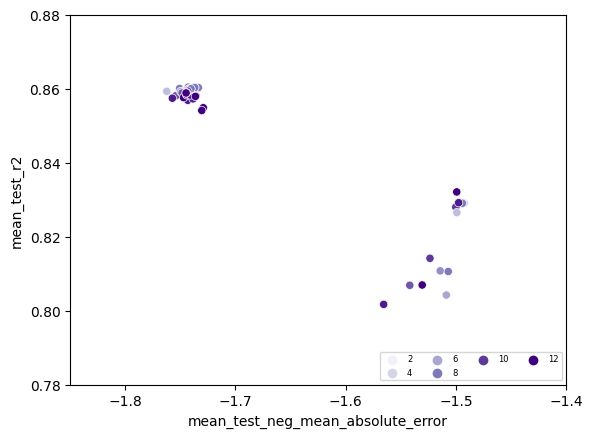

In [66]:
sns.scatterplot(table, x='mean_test_neg_mean_absolute_error', y='mean_test_r2', hue='param_selectkbest__k',  palette='Purples')
plt.legend(loc='lower right',ncols=4, fontsize=6)
plt.xlim([-1.85,-1.4])
plt.ylim((0.78, 0.88))
plt.show()

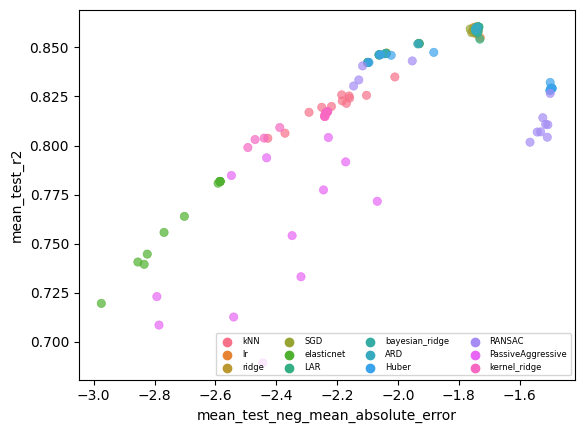

In [61]:
sns.scatterplot(table, x='mean_test_neg_mean_absolute_error', y='mean_test_r2', hue='model', edgecolor='face', alpha=.7)
plt.legend(loc='lower right',ncols=4, fontsize=6)


(0.79, 0.87)

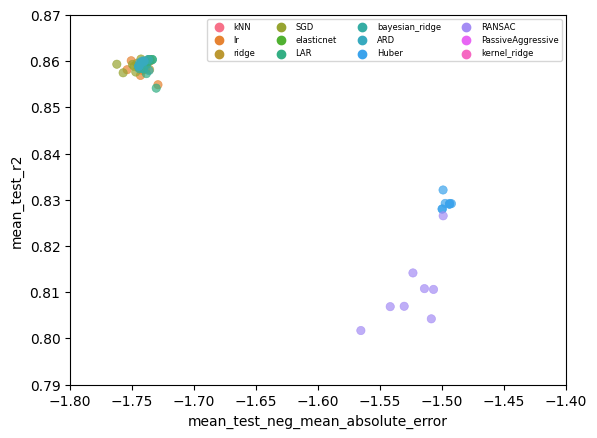

In [59]:
sns.scatterplot(table, x='mean_test_neg_mean_absolute_error', y='mean_test_r2', hue='model', edgecolor='face', alpha=.7)
plt.legend(loc='upper right',ncols=4, fontsize=6)
plt.xlim([-1.8,-1.4])
plt.ylim((0.79, 0.87))

In [39]:
for val in table.model.unique():
    display(table[table.model==val].sort_values('mean_test_neg_root_mean_squared_error',ascending=False).style\
            .background_gradient(subset=['param_selectkbest__k'], cmap='bone')
            .background_gradient(subset=['mean_test_r2'], cmap='viridis_r', vmin=table['mean_test_r2'].min())
            .background_gradient(subset=[
                'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error',
                'mean_test_neg_root_mean_squared_error', 
                                        ], cmap='viridis_r')
            .highlight_max(subset=['mean_test_r2'],  props='font-weight:bold')
            .highlight_max(subset=[
                'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error',
                'mean_test_neg_root_mean_squared_error', 
                                        ],  props='font-weight:bold')
            .format('{:.3f}', subset=table.columns[1:-1]))

,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
6,7,-2.010,-9.307,-3.043,0.835,kNN
8,9,-2.185,-9.855,-3.132,0.826,kNN
7,8,-2.103,-9.863,-3.134,0.826,kNN
10,11,-2.161,-9.891,-3.137,0.825,kNN
5,6,-2.169,-9.996,-3.142,0.821,kNN
9,10,-2.159,-9.958,-3.146,0.824,kNN
3,4,-2.183,-9.993,-3.154,0.823,kNN
4,5,-2.250,-10.156,-3.180,0.819,kNN
11,12,-2.218,-10.194,-3.187,0.820,kNN
2,3,-2.292,-10.398,-3.214,0.817,kNN


,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
18,7,-1.736,-7.894,-2.793,0.860,lr
19,8,-1.751,-7.906,-2.795,0.860,lr
17,6,-1.735,-7.909,-2.795,0.860,lr
16,5,-1.739,-7.936,-2.800,0.860,lr
20,9,-1.754,-8.007,-2.814,0.858,lr
21,10,-1.742,-8.023,-2.816,0.858,lr
22,11,-1.743,-8.090,-2.828,0.857,lr
23,12,-1.729,-8.214,-2.847,0.855,lr
15,4,-1.930,-8.353,-2.878,0.852,lr
14,3,-2.038,-8.652,-2.934,0.847,lr


,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
30,7,-1.736,-7.890,-2.792,0.860,ridge
31,8,-1.736,-7.890,-2.792,0.860,ridge
29,6,-1.741,-7.913,-2.796,0.860,ridge
28,5,-1.746,-7.935,-2.800,0.860,ridge
32,9,-1.740,-7.947,-2.803,0.859,ridge
33,10,-1.743,-8.003,-2.812,0.858,ridge
34,11,-1.739,-8.011,-2.814,0.858,ridge
35,12,-1.736,-8.017,-2.814,0.858,ridge
27,4,-1.931,-8.353,-2.878,0.852,ridge
26,3,-2.039,-8.652,-2.934,0.847,ridge


,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
42,7,-1.738,-7.881,-2.791,0.861,SGD
43,8,-1.744,-7.938,-2.801,0.860,SGD
44,9,-1.744,-7.944,-2.802,0.859,SGD
41,6,-1.756,-7.948,-2.803,0.859,SGD
40,5,-1.762,-7.956,-2.805,0.859,SGD
47,12,-1.745,-7.987,-2.810,0.859,SGD
45,10,-1.750,-7.998,-2.811,0.858,SGD
46,11,-1.757,-8.025,-2.816,0.858,SGD
39,4,-1.929,-8.341,-2.876,0.852,SGD
38,3,-2.039,-8.654,-2.934,0.847,SGD


,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
56,9,-2.585,-12.361,-3.510,0.782,elasticnet
57,10,-2.585,-12.361,-3.510,0.782,elasticnet
59,12,-2.585,-12.361,-3.510,0.782,elasticnet
58,11,-2.585,-12.361,-3.510,0.782,elasticnet
55,8,-2.585,-12.362,-3.510,0.782,elasticnet
54,7,-2.591,-12.412,-3.517,0.781,elasticnet
53,6,-2.702,-13.325,-3.645,0.764,elasticnet
52,5,-2.769,-13.819,-3.713,0.756,elasticnet
51,4,-2.824,-14.433,-3.795,0.745,elasticnet
50,3,-2.855,-14.682,-3.827,0.741,elasticnet


,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
67,8,-1.734,-7.891,-2.792,0.860,LAR
66,7,-1.734,-7.891,-2.792,0.860,LAR
65,6,-1.736,-7.910,-2.796,0.860,LAR
64,5,-1.739,-7.936,-2.800,0.860,LAR
68,9,-1.738,-7.949,-2.803,0.859,LAR
69,10,-1.741,-8.005,-2.812,0.858,LAR
70,11,-1.739,-8.070,-2.824,0.857,LAR
71,12,-1.731,-8.254,-2.854,0.854,LAR
63,4,-1.930,-8.353,-2.878,0.852,LAR
62,3,-2.038,-8.652,-2.934,0.847,LAR


,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
78,7,-1.737,-7.890,-2.792,0.860,bayesian_ridge
79,8,-1.737,-7.890,-2.793,0.860,bayesian_ridge
77,6,-1.740,-7.912,-2.796,0.860,bayesian_ridge
76,5,-1.743,-7.936,-2.800,0.860,bayesian_ridge
80,9,-1.742,-7.947,-2.803,0.859,bayesian_ridge
81,10,-1.744,-8.003,-2.812,0.858,bayesian_ridge
82,11,-1.741,-8.006,-2.813,0.858,bayesian_ridge
83,12,-1.736,-8.028,-2.816,0.858,bayesian_ridge
75,4,-1.930,-8.353,-2.878,0.852,bayesian_ridge
74,3,-2.039,-8.652,-2.934,0.847,bayesian_ridge


,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
88,5,-1.742,-7.908,-2.795,0.860,ARD
91,8,-1.740,-7.907,-2.795,0.860,ARD
90,7,-1.741,-7.913,-2.796,0.860,ARD
89,6,-1.744,-7.929,-2.799,0.860,ARD
92,9,-1.743,-7.943,-2.802,0.859,ARD
93,10,-1.745,-7.968,-2.806,0.859,ARD
94,11,-1.745,-7.969,-2.807,0.859,ARD
95,12,-1.745,-7.971,-2.807,0.859,ARD
87,4,-1.935,-8.361,-2.880,0.852,ARD
86,3,-2.043,-8.658,-2.935,0.847,ARD


,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
99,4,-1.882,-8.593,-2.914,0.847,Huber
97,2,-2.058,-8.693,-2.941,0.846,Huber
98,3,-2.022,-8.704,-2.943,0.846,Huber
96,1,-2.095,-8.889,-2.975,0.842,Huber
107,12,-1.499,-9.538,-3.046,0.832,Huber
101,6,-1.494,-9.679,-3.074,0.829,Huber
100,5,-1.493,-9.681,-3.074,0.829,Huber
102,7,-1.494,-9.688,-3.075,0.829,Huber
103,8,-1.494,-9.688,-3.075,0.829,Huber
106,11,-1.498,-9.693,-3.078,0.829,Huber


,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
111,4,-1.954,-9.197,-3.013,0.836,RANSAC
108,1,-2.158,-9.313,-3.046,0.835,RANSAC
110,3,-2.151,-9.715,-3.104,0.829,RANSAC
113,6,-1.551,-10.003,-3.131,0.823,RANSAC
115,8,-1.491,-10.160,-3.143,0.821,RANSAC
109,2,-2.180,-10.224,-3.169,0.820,RANSAC
114,7,-1.513,-10.286,-3.174,0.818,RANSAC
112,5,-1.529,-10.478,-3.206,0.815,RANSAC
119,12,-1.519,-10.670,-3.225,0.812,RANSAC
118,11,-1.552,-10.703,-3.249,0.812,RANSAC


,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
124,5,-2.126,-11.539,-3.362,0.796,PassiveAggressive
123,4,-2.426,-11.811,-3.411,0.793,PassiveAggressive
127,8,-2.254,-12.109,-3.462,0.786,PassiveAggressive
120,1,-2.634,-12.818,-3.533,0.771,PassiveAggressive
128,9,-2.219,-12.742,-3.540,0.776,PassiveAggressive
122,3,-2.598,-12.703,-3.552,0.773,PassiveAggressive
121,2,-2.660,-13.019,-3.602,0.768,PassiveAggressive
129,10,-2.435,-13.878,-3.630,0.758,PassiveAggressive
131,12,-2.226,-13.482,-3.646,0.760,PassiveAggressive
125,6,-2.181,-13.939,-3.680,0.755,PassiveAggressive


,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
138,7,-2.231,-10.317,-3.199,0.817,kernel_ridge
139,8,-2.231,-10.317,-3.199,0.817,kernel_ridge
137,6,-2.233,-10.340,-3.202,0.817,kernel_ridge
136,5,-2.238,-10.355,-3.205,0.817,kernel_ridge
140,9,-2.237,-10.376,-3.208,0.816,kernel_ridge
141,10,-2.242,-10.441,-3.218,0.815,kernel_ridge
142,11,-2.241,-10.462,-3.221,0.815,kernel_ridge
143,12,-2.239,-10.467,-3.221,0.815,kernel_ridge
135,4,-2.388,-10.758,-3.271,0.809,kernel_ridge
134,3,-2.440,-11.072,-3.321,0.804,kernel_ridge


In [108]:
display(table.sort_values('mean_test_r2',ascending=False).reset_index(drop=True).style\
        .background_gradient(subset=['param_selectkbest__k'], cmap='bone')
        #.background_gradient(subset=['model'], cmap='Pastel2'),
        .background_gradient(subset=['mean_test_r2'], cmap='viridis_r')
        .background_gradient(subset=[
            'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error',
            'mean_test_neg_root_mean_squared_error', 
                                    ], cmap='viridis_r')
        .highlight_max(subset=['mean_test_r2'],  props='font-weight:bold')
        .highlight_max(subset=[
            'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error',
            'mean_test_neg_root_mean_squared_error', 
                                    ],  props='font-weight:bold')
        .format('{:.3f}', subset=table.columns[1:-1]))

,param_selectkbest__k,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_test_r2,model
0,7,-1.738,-7.881,-2.791,0.861,SGD
1,8,-1.736,-7.890,-2.792,0.860,ridge
2,7,-1.736,-7.890,-2.792,0.860,ridge
3,7,-1.737,-7.890,-2.792,0.860,bayesian_ridge
4,8,-1.737,-7.890,-2.793,0.860,bayesian_ridge
5,7,-1.734,-7.891,-2.792,0.860,LAR
6,8,-1.734,-7.891,-2.792,0.860,LAR
7,7,-1.736,-7.894,-2.793,0.860,lr
8,8,-1.751,-7.906,-2.795,0.860,lr
9,6,-1.735,-7.909,-2.795,0.860,lr


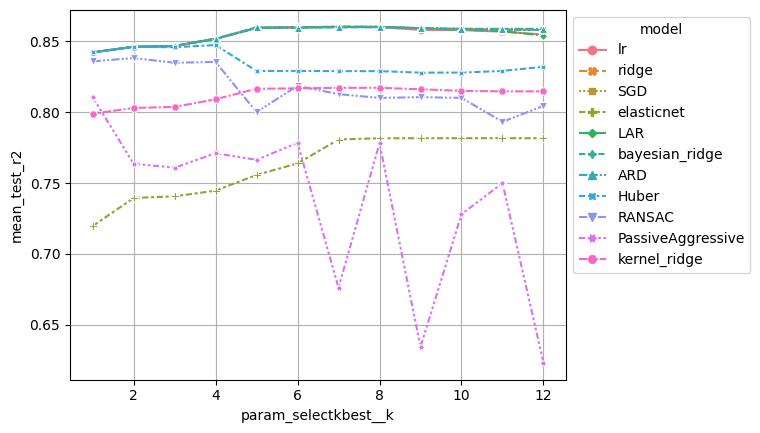

In [27]:
ax = sns.lineplot(table, x='param_selectkbest__k', y='mean_test_r2', hue='model', style='model',
                 markers=True, dashes=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.yscale('log')
#plt.ylim([0.858,0.861])
plt.grid()
plt.savefig('linear-models_feature-selection.png', bbox_inches='tight')
plt.show()

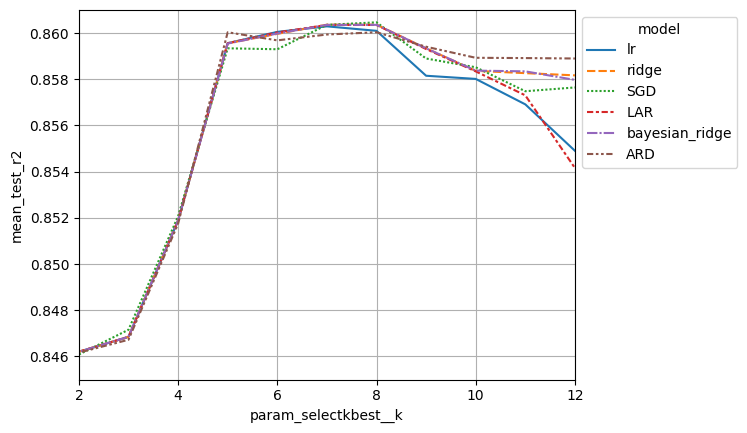

In [12]:
selection = ['lr','ridge','SGD','LAR','ARD', 'bayesian_ridge']
ax = sns.lineplot(table[table.model.isin(selection)], x='param_selectkbest__k', y='mean_test_r2', hue='model', style='model',
                 markers=False, dashes=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.yscale('log')
plt.ylim([0.845,0.861])
plt.xlim([2,12])
plt.grid()
#plt.savefig('linear-models_feature-selection-zoomed.png', bbox_inches='tight')
plt.show()


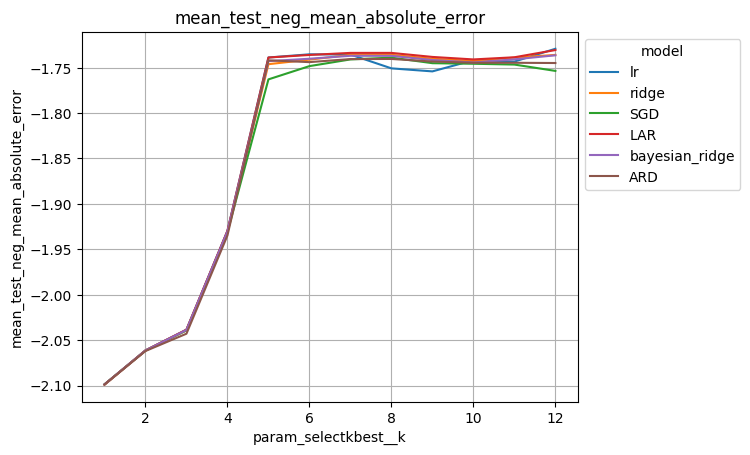

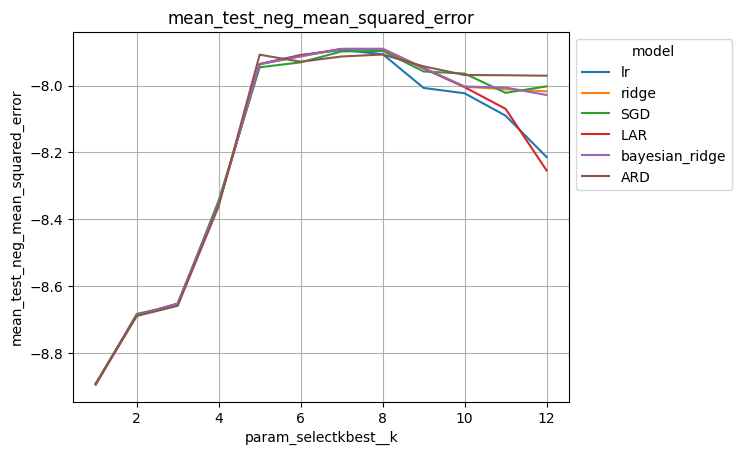

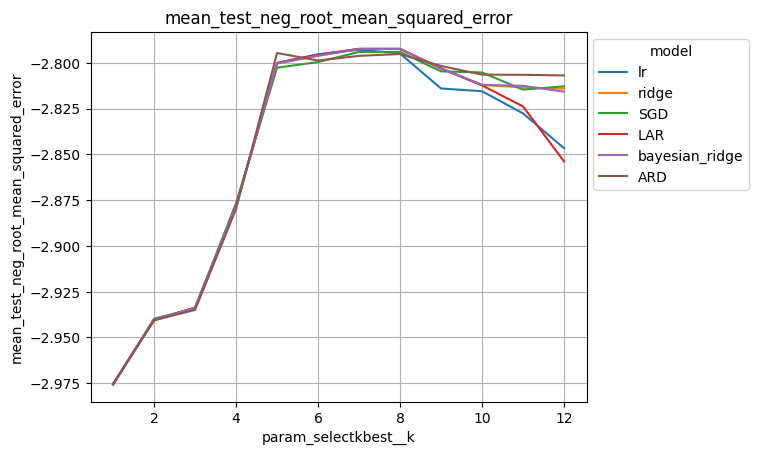

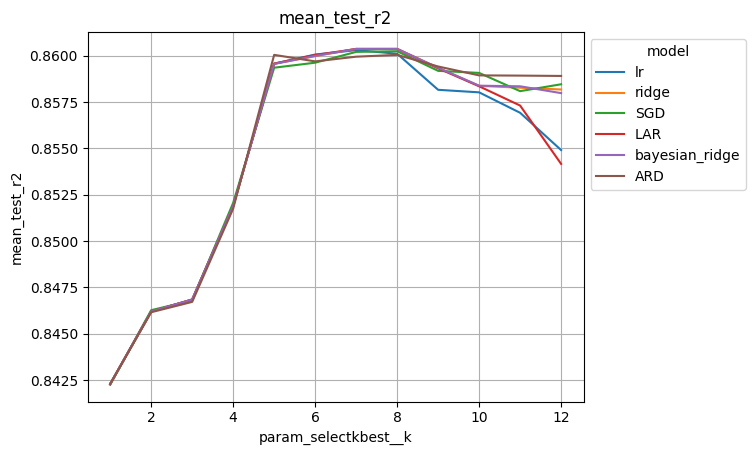

In [31]:
selection = ['lr','ridge','SGD','LAR','ARD', 'bayesian_ridge']
# selection = ['RANSAC','Huber', 'kernel_ridge']
# selection = ['PassiveAggressive', 'elasticnet', 'kernel_ridge']

for i in range(1,len(score_cols)):
    ax = sns.lineplot(table[table.model.isin(selection)], x='param_selectkbest__k', y=score_cols[i], hue='model')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(score_cols[i])
    plt.grid()
    plt.savefig(f'linear-models_feature-selection_{score_cols[i].replace("mean_test_","")}.png', bbox_inches='tight')
    plt.show()

#### Normalization
- utilize pycaret to easily compare models
  - models chosen for tuning study listed above
- table metric background colors
  - **<font color="yellow">Good</font> | <font color="aquamarine">Fair</font> | <font color="purple">Bad</font>** 
- see printouts at the end of section for clearer results, tables not presented side-by-side

In [6]:
from pycaret.regression import *

##### Experiment Using All Data
*test unscaled vs normalized data, how do model metrics compare?*

In [170]:
# unscaled
s = setup(pd.concat([X, y1], axis=1), target = 'home_margin', session_id = 42,
           train_size=0.75, verbose=False)

In [173]:
%%time

# compare baseline models, return best for plots
best = compare_models(include=['catboost','et','lightgbm','rf','xgboost','ada','dt','gbr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.5650,6.4505,2.4964,0.8876,0.4169,0.4868,1.2070
et,Extra Trees Regressor,1.7864,7.2694,2.6634,0.8731,0.4303,0.5662,0.3110
lightgbm,Light Gradient Boosting Machine,1.7553,7.3098,2.6796,0.8725,0.4379,0.5497,0.0640
gbr,Gradient Boosting Regressor,1.8113,7.8076,2.7614,0.8637,0.4365,0.5542,0.0480
rf,Random Forest Regressor,1.8773,8.0601,2.8124,0.8589,0.4460,0.5958,0.1220
xgboost,Extreme Gradient Boosting,1.8253,8.1438,2.8189,0.8577,0.4496,0.5798,0.0600
ada,AdaBoost Regressor,2.5680,11.9212,3.4290,0.7910,0.5470,0.8814,0.0280
dt,Decision Tree Regressor,2.5737,14.1298,3.7476,0.7495,0.5395,0.8255,0.0100


CPU times: total: 20.4 s
Wall time: 26.8 s


In [174]:
results_table_all = pull()

In [175]:
display(results_table_all.sort_values('R2',ascending=False).style\
        .background_gradient(subset=['R2'], cmap='viridis', vmin=0.7)
        .background_gradient(subset=['MAE','RMSE','MAPE'], cmap='viridis_r')
        .highlight_max(subset=['R2'],  props='font-weight:bold')
        .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
        .format('{:.3f}', subset=results_table_all.columns[1:]))

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.565,6.450,2.496,0.888,0.417,0.487,1.207
et,Extra Trees Regressor,1.786,7.269,2.663,0.873,0.430,0.566,0.311
lightgbm,Light Gradient Boosting Machine,1.755,7.310,2.680,0.873,0.438,0.550,0.064
gbr,Gradient Boosting Regressor,1.811,7.808,2.761,0.864,0.436,0.554,0.048
rf,Random Forest Regressor,1.877,8.060,2.812,0.859,0.446,0.596,0.122
xgboost,Extreme Gradient Boosting,1.825,8.144,2.819,0.858,0.450,0.580,0.060
ada,AdaBoost Regressor,2.568,11.921,3.429,0.791,0.547,0.881,0.028
dt,Decision Tree Regressor,2.574,14.130,3.748,0.750,0.539,0.826,0.010


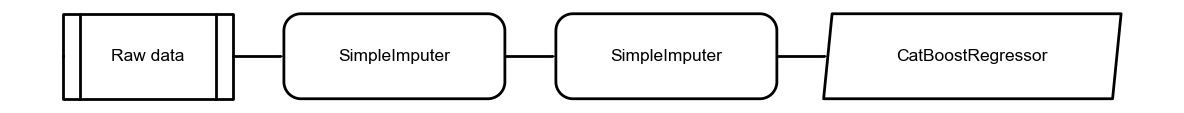

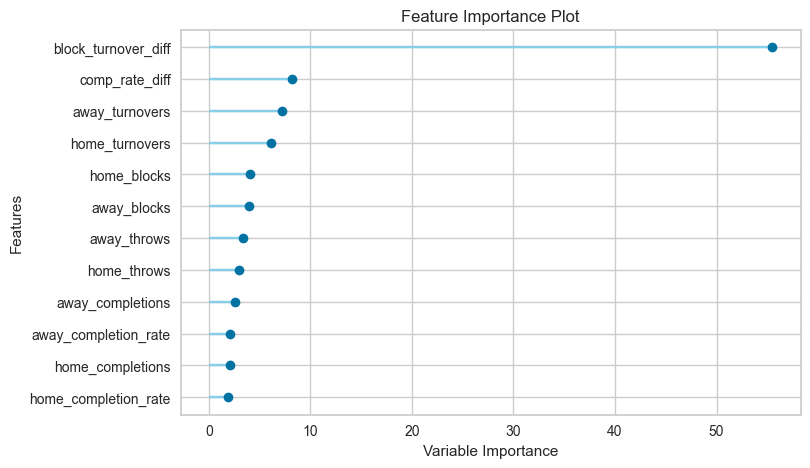

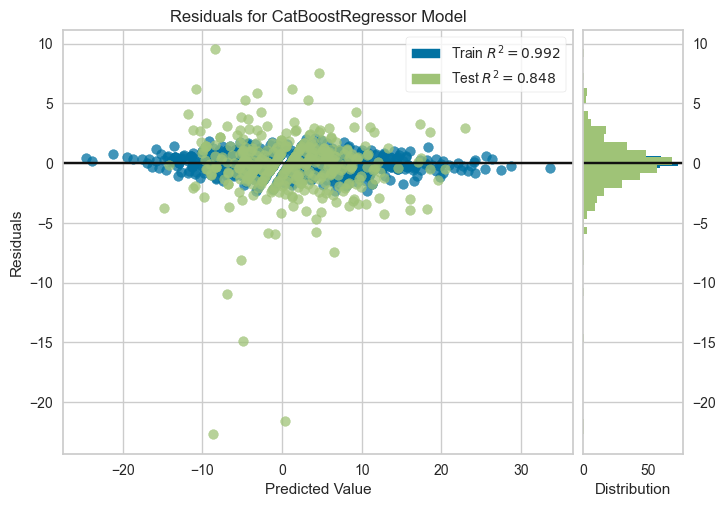

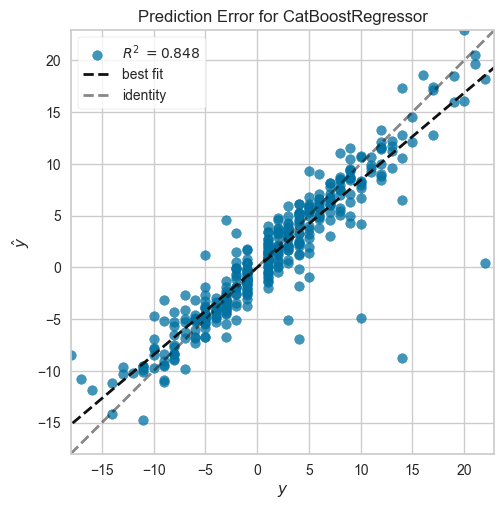

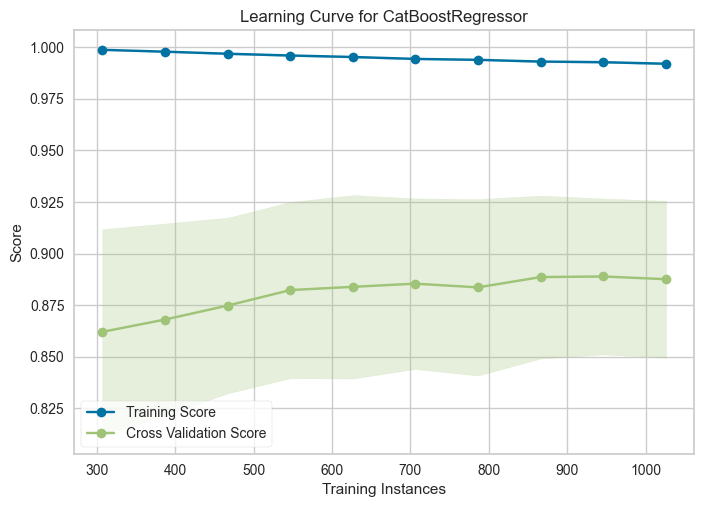

In [42]:
for plot_type in ['pipeline','feature_all','residuals', 'error', 'learning']:
    try:
        plot_model(best, plot=plot_type)
    except:
        print('error for',plot_type, 'graph.')

In [176]:
# normalize data
s = setup(pd.concat([X, y1], axis=1), target = 'home_margin', session_id = 42, train_size=0.75,
          normalize=True, verbose=False)

In [177]:
%%time
_ = compare_models(include=['catboost','et','lightgbm','rf','xgboost','ada','dt','gbr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.5644,6.4476,2.4955,0.8877,0.4167,0.4867,0.6540
lightgbm,Light Gradient Boosting Machine,1.7562,7.2576,2.6654,0.8736,0.4398,0.5449,0.0660
et,Extra Trees Regressor,1.7867,7.2726,2.6639,0.8731,0.4303,0.5662,0.0630
gbr,Gradient Boosting Regressor,1.8106,7.7902,2.7576,0.8640,0.4358,0.5539,0.0500
rf,Random Forest Regressor,1.8789,8.0559,2.8118,0.8590,0.4460,0.5963,0.1310
xgboost,Extreme Gradient Boosting,1.8253,8.1438,2.8189,0.8577,0.4496,0.5798,0.0680
ada,AdaBoost Regressor,2.5896,11.9337,3.4322,0.7907,0.5627,0.8946,0.0310
dt,Decision Tree Regressor,2.5588,13.8272,3.7083,0.7551,0.5389,0.8218,0.0110


CPU times: total: 20.1 s
Wall time: 19 s


In [178]:
results_table_scaled = pull()

In [180]:
display(results_table_all.sort_values('R2',ascending=False).style\
        .background_gradient(subset=['R2'], cmap='viridis', vmin=0.7)
        .background_gradient(subset=['MAE','RMSE','MAPE'], cmap='viridis_r')
        .highlight_max(subset=['R2'],  props='font-weight:bold')
        .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
        .format('{:.3f}', subset=results_table_all.columns[1:]))

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.565,6.450,2.496,0.888,0.417,0.487,1.207
et,Extra Trees Regressor,1.786,7.269,2.663,0.873,0.430,0.566,0.311
lightgbm,Light Gradient Boosting Machine,1.755,7.310,2.680,0.873,0.438,0.550,0.064
gbr,Gradient Boosting Regressor,1.811,7.808,2.761,0.864,0.436,0.554,0.048
rf,Random Forest Regressor,1.877,8.060,2.812,0.859,0.446,0.596,0.122
xgboost,Extreme Gradient Boosting,1.825,8.144,2.819,0.858,0.450,0.580,0.060
ada,AdaBoost Regressor,2.568,11.921,3.429,0.791,0.547,0.881,0.028
dt,Decision Tree Regressor,2.574,14.130,3.748,0.750,0.539,0.826,0.010


In [179]:
display(results_table_scaled.sort_values('R2',ascending=False).style\
        .background_gradient(subset=['R2'], cmap='viridis', vmin=0.7)
        .background_gradient(subset=['MAE','RMSE','MAPE'], cmap='viridis_r')
        .highlight_max(subset=['R2'],  props='font-weight:bold')
        .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
        .format('{:.3f}', subset=results_table_scaled.columns[1:]))

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.564,6.448,2.495,0.888,0.417,0.487,0.654
lightgbm,Light Gradient Boosting Machine,1.756,7.258,2.665,0.874,0.440,0.545,0.066
et,Extra Trees Regressor,1.787,7.273,2.664,0.873,0.430,0.566,0.063
gbr,Gradient Boosting Regressor,1.811,7.790,2.758,0.864,0.436,0.554,0.050
rf,Random Forest Regressor,1.879,8.056,2.812,0.859,0.446,0.596,0.131
xgboost,Extreme Gradient Boosting,1.825,8.144,2.819,0.858,0.450,0.580,0.068
ada,AdaBoost Regressor,2.590,11.934,3.432,0.791,0.563,0.895,0.031
dt,Decision Tree Regressor,2.559,13.827,3.708,0.755,0.539,0.822,0.011


In [181]:
for val in results_table_scaled.index:
    print(val,'|', results_table_scaled.loc[val,'Model'])
    for metric in ['RMSE','MAPE']:
        if results_table_scaled.loc[val,metric] == results_table_all.loc[val,metric]:
            print(metric,'\tno benefit to normalization')
        elif results_table_scaled.loc[val,metric] < results_table_all.loc[val,metric]:
            print(metric,'\tnormalization improves performance')
        else:
            print(metric,'\tperforms worse with normalization')
    for metric in ['R2']:
        if results_table_scaled.loc[val,metric] == results_table_all.loc[val,metric]:
            print(metric, '\tno benefit to normalization')
        elif results_table_scaled.loc[val,metric] > results_table_all.loc[val,metric]:
            print(metric,'\tnormalization improves performance')
        else:
            print(metric,'\tperforms worse with normalization')
    
    
    print()
    print()

catboost | CatBoost Regressor
RMSE 	normalization improves performance
MAPE 	normalization improves performance
R2 	normalization improves performance


lightgbm | Light Gradient Boosting Machine
RMSE 	normalization improves performance
MAPE 	normalization improves performance
R2 	normalization improves performance


et | Extra Trees Regressor
RMSE 	performs worse with normalization
MAPE 	no benefit to normalization
R2 	no benefit to normalization


gbr | Gradient Boosting Regressor
RMSE 	normalization improves performance
MAPE 	normalization improves performance
R2 	normalization improves performance


rf | Random Forest Regressor
RMSE 	normalization improves performance
MAPE 	performs worse with normalization
R2 	normalization improves performance


xgboost | Extreme Gradient Boosting
RMSE 	no benefit to normalization
MAPE 	no benefit to normalization
R2 	no benefit to normalization


ada | AdaBoost Regressor
RMSE 	performs worse with normalization
MAPE 	performs worse with normaliza

##### Experiment with 7,8 Features Selected
*testing effects of standardization, skip no scaling for SGD*

In [61]:
%%time

SGD_results = pd.DataFrame()

for condition in [(8,True), (7,True)]:
    study = f'{condition[0]}-features_{"normalized" if condition[1] else "unscaled"}'
    
    s = setup(pd.concat([X, y1], axis=1), target = 'home_margin', session_id = 42, train_size=0.75,
              feature_selection=True, feature_selection_method='univariate', 
              n_features_to_select=condition[0], normalize=condition[1], verbose=False)
    sgd = create_model(SGDRegressor(), verbose=False)
    r = pull().loc['Mean']
    print(study,'\n',r)
    SGD_results.loc[study, r.index] = r

8-features_normalized 
 MAE      1.7224
MSE      7.8025
RMSE     2.7576
R2       0.8634
RMSLE    0.4346
MAPE     0.5442
Name: Mean, dtype: float64
7-features_normalized 
 MAE      1.7204
MSE      7.8018
RMSE     2.7572
R2       0.8634
RMSLE    0.4343
MAPE     0.5456
Name: Mean, dtype: float64
CPU times: total: 5.67 s
Wall time: 5.76 s


In [64]:
SGD_results

,MAE,MSE,RMSE,R2,RMSLE,MAPE
8-features_normalized,1.7224,7.8025,2.7576,0.8634,0.4346,0.5442
7-features_normalized,1.7204,7.8018,2.7572,0.8634,0.4343,0.5456


In [57]:
%%time

results_tables = {}

for condition in [(8,False), (7,False), (8,True), (7,True)]:
    study = f'{condition[0]}-features_{"normalized" if condition[1] else "unscaled"}'
    print(study)
    
    s = setup(pd.concat([X, y1], axis=1), target = 'home_margin', session_id = 42, train_size=0.75,
              feature_selection=True, feature_selection_method='univariate', 
              n_features_to_select=condition[0], normalize=condition[1], verbose=False)
    _ = compare_models(include=['lr','ridge','lar','llar','br','ard','kr','knn'], verbose = False)
    
    results_tables[study] = pull()

8-features_unscaled
7-features_unscaled
8-features_normalized
7-features_normalized
CPU times: total: 17.2 s
Wall time: 19.1 s


In [58]:
for key,val in results_tables.items():
    print(key)
    print(val.describe().loc[['mean','std'],:].round(3))
    print()

8-features_unscaled
        MAE    MSE   RMSE     R2  RMSLE   MAPE  TT (Sec)
mean  1.744  7.807  2.756  0.863  0.435  0.551     0.011
std   0.058  0.136  0.028  0.002  0.014  0.018     0.003

7-features_unscaled
        MAE    MSE   RMSE     R2  RMSLE   MAPE  TT (Sec)
mean  1.744  7.812  2.757  0.863  0.435  0.550     0.011
std   0.058  0.139  0.028  0.002  0.013  0.018     0.002

8-features_normalized
        MAE    MSE   RMSE     R2  RMSLE   MAPE  TT (Sec)
mean  1.896  8.608  2.896  0.849  0.456  0.583     0.012
std   0.250  1.111  0.191  0.019  0.033  0.061     0.004

7-features_normalized
        MAE    MSE   RMSE     R2  RMSLE   MAPE  TT (Sec)
mean  1.882  8.524  2.882  0.851  0.454  0.579     0.012
std   0.242  1.028  0.177  0.018  0.032  0.060     0.003



In [65]:
# include SGD results
for val in SGD_results.index:
    scores = SGD_results.loc[val]
    results_tables[val].loc['sgd','Model'] = 'SGDRegressor'
    results_tables[val].loc['sgd',scores.index] = scores

In [66]:
for key,val in results_tables.items():
    print(key)
    display(val.sort_values('R2',ascending=False).style\
            .background_gradient(subset=['R2'], cmap='viridis')
            .background_gradient(subset=['MAE','RMSE','MAPE'], cmap='viridis_r')
            .highlight_max(subset=['R2'],  props='font-weight:bold')
            .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
            .format('{:.3f}', subset=val.columns[1:]))

8-features_unscaled


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,1.751,7.521,2.699,0.868,0.417,0.531,0.014
lr,Linear Regression,1.719,7.802,2.757,0.863,0.435,0.549,0.011
ridge,Ridge Regression,1.716,7.802,2.755,0.863,0.431,0.546,0.011
lar,Least Angle Regression,1.716,7.811,2.759,0.863,0.432,0.544,0.009
kr,Kernel Ridge,1.718,7.807,2.755,0.863,0.431,0.547,0.018
ard,Automatic Relevance Determination,1.721,7.837,2.763,0.863,0.432,0.545,0.009
br,Bayesian Ridge,1.730,7.851,2.763,0.863,0.434,0.550,0.009
llar,Lasso Least Angle Regression,1.885,8.020,2.802,0.860,0.466,0.593,0.008


7-features_unscaled


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,1.751,7.516,2.698,0.868,0.419,0.530,0.012
lar,Least Angle Regression,1.716,7.811,2.759,0.863,0.432,0.544,0.009
kr,Kernel Ridge,1.718,7.808,2.755,0.863,0.431,0.547,0.016
lr,Linear Regression,1.716,7.821,2.760,0.863,0.431,0.546,0.009
ridge,Ridge Regression,1.718,7.816,2.756,0.863,0.431,0.547,0.010
br,Bayesian Ridge,1.730,7.851,2.763,0.863,0.434,0.550,0.010
ard,Automatic Relevance Determination,1.721,7.854,2.765,0.863,0.432,0.546,0.011
llar,Lasso Least Angle Regression,1.885,8.020,2.802,0.860,0.466,0.593,0.009


8-features_normalized


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
sgd,SGDRegressor,1.722,7.803,2.758,0.863,0.435,0.544,nan
lr,Linear Regression,1.720,7.806,2.757,0.863,0.435,0.546,0.010
ridge,Ridge Regression,1.718,7.810,2.758,0.863,0.433,0.545,0.010
lar,Least Angle Regression,1.716,7.811,2.759,0.863,0.432,0.544,0.011
br,Bayesian Ridge,1.719,7.810,2.758,0.863,0.433,0.545,0.011
ard,Automatic Relevance Determination,1.721,7.837,2.763,0.863,0.432,0.545,0.011
llar,Lasso Least Angle Regression,2.251,9.689,3.087,0.831,0.507,0.623,0.011
knn,K Neighbors Regressor,2.079,9.782,3.098,0.829,0.476,0.608,0.016
kr,Kernel Ridge,2.244,10.323,3.187,0.820,0.499,0.712,0.020


7-features_normalized


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
sgd,SGDRegressor,1.720,7.802,2.757,0.863,0.434,0.546,nan
ridge,Ridge Regression,1.718,7.809,2.758,0.863,0.432,0.545,0.010
lar,Least Angle Regression,1.716,7.811,2.759,0.863,0.432,0.544,0.010
br,Bayesian Ridge,1.719,7.809,2.758,0.863,0.433,0.545,0.010
lr,Linear Regression,1.716,7.814,2.759,0.863,0.433,0.545,0.010
ard,Automatic Relevance Determination,1.721,7.854,2.765,0.863,0.432,0.546,0.010
knn,K Neighbors Regressor,1.969,9.087,2.983,0.841,0.464,0.577,0.014
llar,Lasso Least Angle Regression,2.251,9.689,3.087,0.831,0.507,0.623,0.011
kr,Kernel Ridge,2.244,10.323,3.187,0.820,0.499,0.712,0.019


In [67]:
for key,val in results_tables.items():
    val.loc[:,'study'] = key

In [68]:
big_table = pd.concat([val for val in results_tables.values()]).reset_index(drop=True)

In [69]:
for m in big_table.Model.unique():
    print(m)
    t = big_table[big_table.Model==m]
    for metric in ['RMSE','MAE','MAPE']:
        best = t[t[metric]==t[metric].min()].study.values
        print('best',metric,best)
    for metric in ['R2']:
        best = t[t[metric]==t[metric].max()].study.values
        print('best',metric,best)    
    print()

K Neighbors Regressor
best RMSE ['7-features_unscaled']
best MAE ['7-features_unscaled']
best MAPE ['7-features_unscaled']
best R2 ['7-features_unscaled']

Linear Regression
best RMSE ['8-features_unscaled']
best MAE ['7-features_unscaled']
best MAPE ['7-features_normalized']
best R2 ['8-features_unscaled']

Ridge Regression
best RMSE ['8-features_unscaled']
best MAE ['8-features_unscaled']
best MAPE ['8-features_normalized' '7-features_normalized']
best R2 ['8-features_unscaled']

Least Angle Regression
best RMSE ['8-features_unscaled' '7-features_unscaled' '8-features_normalized'
 '7-features_normalized']
best MAE ['8-features_unscaled' '7-features_unscaled' '8-features_normalized'
 '7-features_normalized']
best MAPE ['8-features_unscaled' '7-features_unscaled' '8-features_normalized'
 '7-features_normalized']
best R2 ['8-features_unscaled' '7-features_unscaled' '8-features_normalized'
 '7-features_normalized']

Kernel Ridge
best RMSE ['8-features_unscaled']
best MAE ['8-features_uns

**<font color="darkgreen">Analysis</font>**

**Mix of results for whethere 7,8 features or whether to scale or not scale. Will likely test again and eliminate obvious conditions for certain models. . . see below**

- normalization always better
  - Bayesian Ridge, SGD (determined previously)
- normalization always worse
  - LLAR, Kernel Ridge, kNN